In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.vision import *
from pathlib import Path

In [3]:
%cd
%cd '/content/drive/My Drive/gender recognition'

/root
/content/drive/My Drive/gender recognition


In [13]:
path = Path('/content/drive/My Drive/gender recognition')
path.ls()


[PosixPath('/content/drive/My Drive/gender recognition/val.zip'),
 PosixPath('/content/drive/My Drive/gender recognition/test.zip'),
 PosixPath('/content/drive/My Drive/gender recognition/train.zip'),
 PosixPath('/content/drive/My Drive/gender recognition/train'),
 PosixPath('/content/drive/My Drive/gender recognition/gender_test.h5'),
 PosixPath('/content/drive/My Drive/gender recognition/gender_test2.h5'),
 PosixPath('/content/drive/My Drive/gender recognition/test'),
 PosixPath('/content/drive/My Drive/gender recognition/valid'),
 PosixPath('/content/drive/My Drive/gender recognition/models'),
 PosixPath('/content/drive/My Drive/gender recognition/name_label.csv')]

In [14]:
c = pd.read_csv(path/'name_label.csv')
print(c.head())

                                                name  label  is_valid
0  train/male/coarse_tilt_aligned_face.911.118313...      1         0
1  train/male/coarse_tilt_aligned_face.911.118496...      1         0
2  train/male/0coarse_tilt_aligned_face.911.11848...      1         0
3  train/male/coarse_tilt_aligned_face.911.118481...      1         0
4  train/male/coarse_tilt_aligned_face.911.118125...      1         0


In [0]:
import cv2
def custom_transform(x): # you get a PyTorch tensor as input, not a fastai Image object
    npim = image2np(x)*255 # convert to numpy array in range 0-255
    npim = npim.astype(np.uint8) # convert to int
	
    # If your image is a regular colour image, remember it will be in RGB so convert to BGR if needed
    img_bgr = cv2.cvtColor(npim, cv2.COLOR_BGR2GRAY)
	
    # transform using opencv
    # ...
    # don't forget to convert back to RGB if needed

    # assuming result image is stored in result_img
    return pil2tensor(img_bgr, dtype=np.float32)/255 # convert back to tensor and return

custom_trans = TfmPixel(custom_transform) # wrap in TfmPixel to create a valid transform

In [0]:
tfms = get_transforms(xtra_tfms=[custom_trans()], 
                      do_flip=True, 
                      flip_vert=False, 
                      max_rotate=20.0,
                      max_zoom=1.1,  
                     )

In [0]:
np.random.seed(42)
np.random.seed(42)
src = (ImageList.from_csv(path, 'name_label.csv')
        .split_from_df(col='is_valid')
        .label_from_df()
      )

In [18]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/fastai/basic_data.py:259: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 3191,6265,1942
  warn(warn_msg)


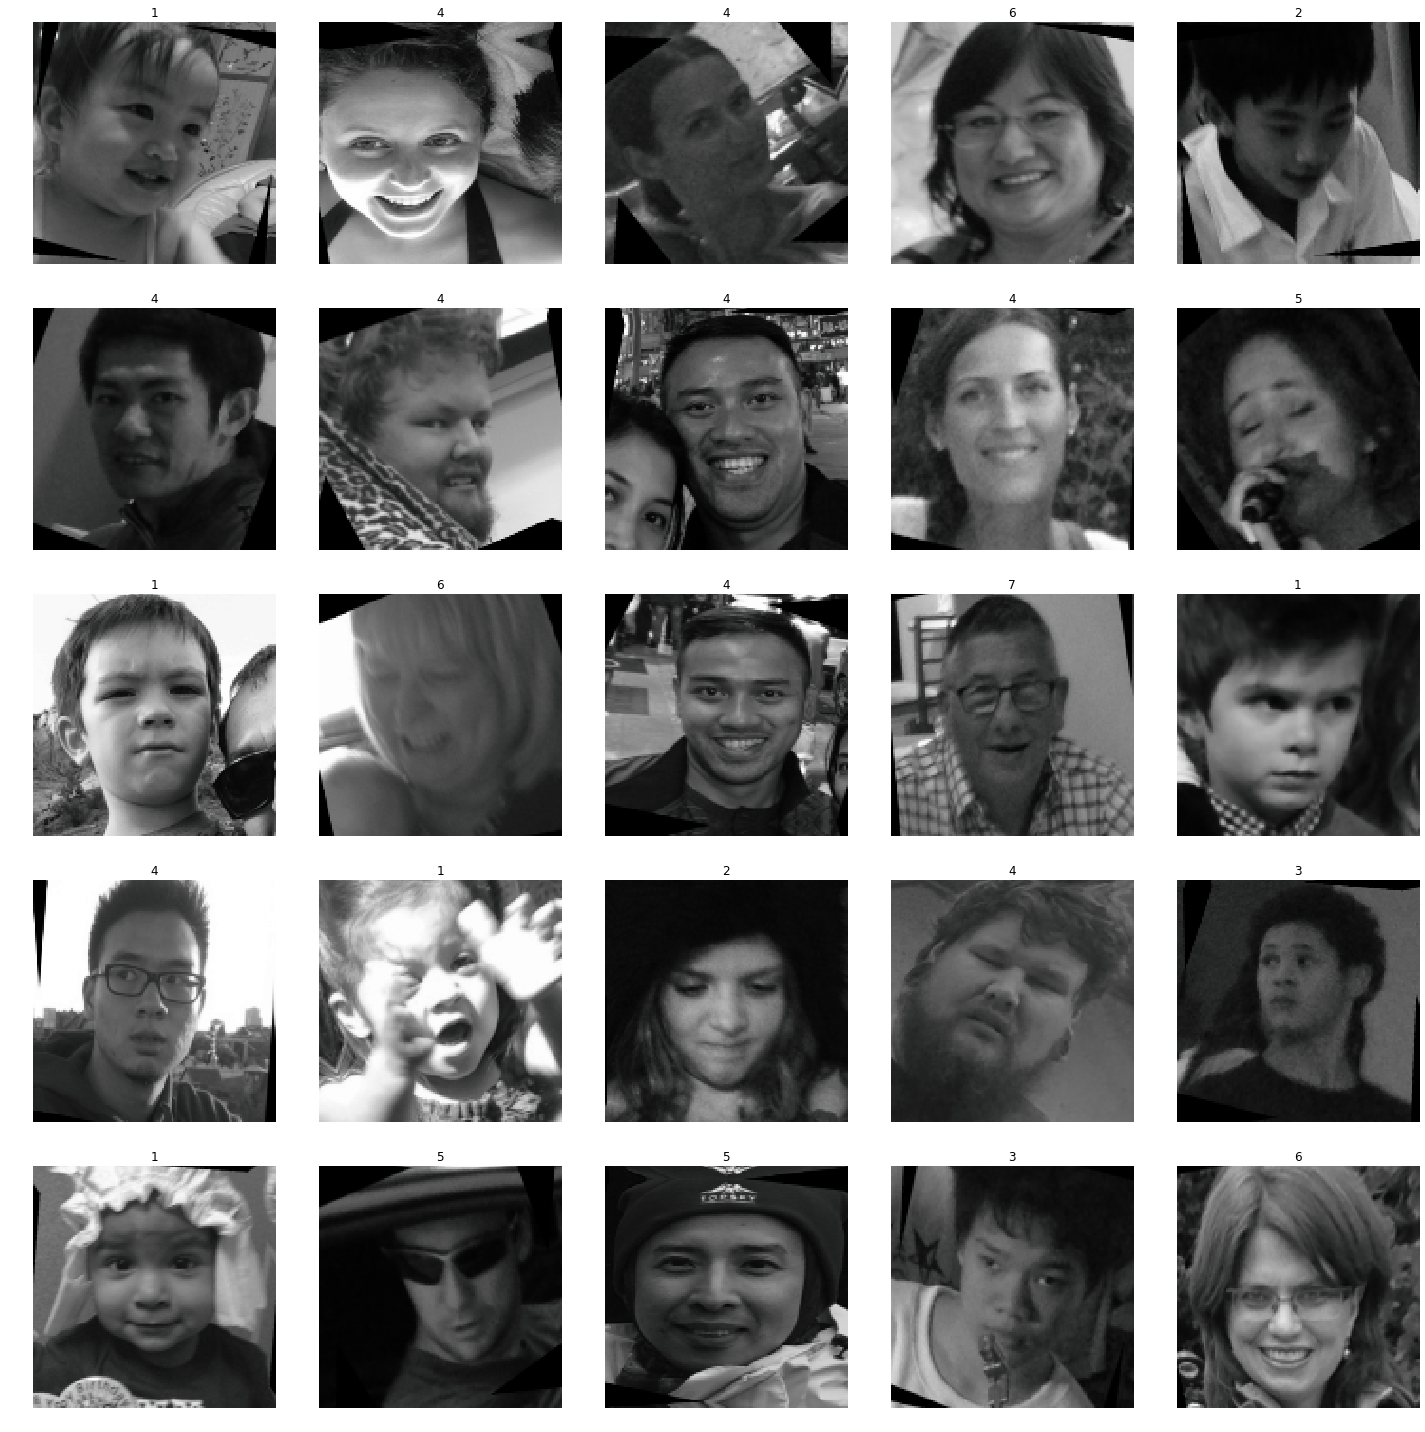

In [0]:
data.show_batch()

In [0]:
data.classes

[1, 2, 3, 4, 5, 6, 7]

In [19]:
learn = cnn_learner(data, models.resnet34, metrics = [accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:07<00:00, 12319509.24it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.598091,1.373547,0.466908,0.533092,06:22
1,1.321793,1.252228,0.506039,0.493961,06:34
2,1.176256,1.168299,0.543237,0.456763,07:07
3,1.129869,1.157277,0.551691,0.448309,05:50


In [0]:
learn.save('stage_1_age_128')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


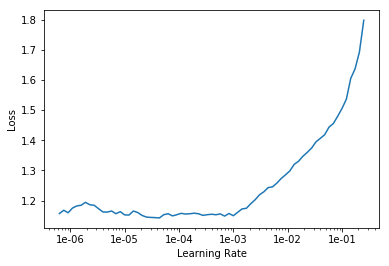

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, slice(1e-4, 1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time


In [0]:
learn.save('stage_2_age_128')

In [24]:
learn.load('stage_2_age_128')

Learner(data=ImageDataBunch;

Train: LabelList (13499 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: CategoryList
1,1,1,1,1
Path: /content/drive/My Drive/gender recognition;

Valid: LabelList (4140 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: /content/drive/My Drive/gender recognition;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


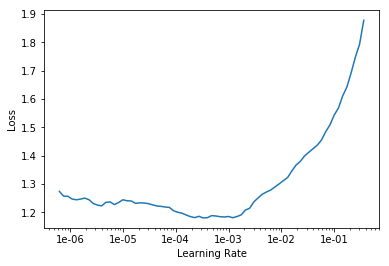

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(2, slice(1e-4, 1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.925446,0.966483,0.621014,0.378985,27:29


KeyboardInterrupt: ignored

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


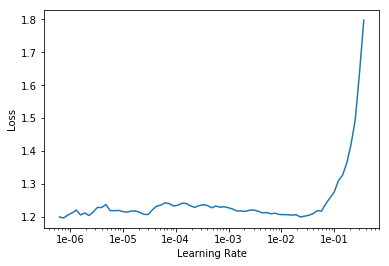

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(2, slice(1e-3, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.077164,1.027654,0.584300,0.415700,04:51
1,1.013375,1.024336,0.589855,0.410145,04:51


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


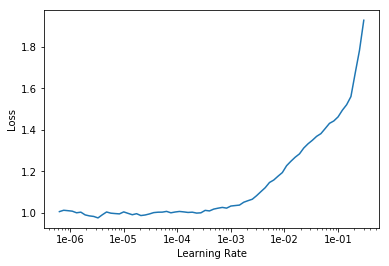

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(2, slice(1e-4, 1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.873312,0.876260,0.659662,0.340338,05:01
1,0.728360,0.806338,0.690097,0.309903,05:01


In [0]:
learn.save('stage_1_age_256')

# Making the csv for training

In [0]:
cwd = os.getcwd()
%cd ../

/content/drive/My Drive


In [0]:
import os
import progressbar
import shutil
import pandas as pd
from IPython.display import HTML, display
import time

def making_csv():
    cwd = os.getcwd()
    dirs = os.listdir(cwd)
    lines = []
    for i in dirs:
        a = i.split('_')
        if(len(a) >= 2):
            if(a[0] == 'fold'):
                file = open(i, 'r')
                l = file.readlines()
                for ii in l:
                    lines.append(str(ii))
      
    print(lines)
    is_valid = []
    main_folder = os.path.join(cwd, 'gender recognition')
    # main_folder = cwd
    sub_folder = os.listdir(main_folder)        # train, test, val
    print(sub_folder)
    files_names = []
    for i in sub_folder:
        s = os.path.join(main_folder, str(i))
        if(i != 'test' and i != 'train' and i != 'valid'):
            continue
        female_male = os.listdir(s)
        for j in female_male:
            name = os.path.join(main_folder, str(i)+'/'+str(j))
            files = os.listdir(name)
            for k in files:
                if(i == 'valid'):
                    files_names.append((str(k), 1, i, j))
                else:
                    files_names.append((str(k), 0, i, j))
    print(files_names)
    # (0-2)->1, (4-6)->2, (8-12)->3, (15-20)->4, (25-32)->5, (38-43)->6, (48-53)->7, (60-100)->8 
    cat = ['(0, 2)', '(4, 6)', '(8, 12)', '(8, 23)', '(15, 20)', '(25, 32)', '(27, 32)', '(38, 42)', '(38, 43)', '(38, 48)', '(48, 53)', '(60, 100)']
            # 0->1     1->1      2->3       3->4        4->4        5->5       6->5         7->6        8->6        9->6        10->7       11->8           
    age_c = []
    for i in lines:
        line = i.split('\t')
        age = line[3]
        if(age not in  age_c):
            if(len(age.split()) > 1):
                age_c.append(age)
    print(age_c)
    name_csv = []
    label_csv = []
    valid = []
    
    per = 0
    bar = progressbar.ProgressBar(maxval=len(lines), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    for i in lines:
        bar.update(per+1)
        per+=1
        line = i.split('\t')
        if(len(line) < 4):
            continue
        name = line[1]
        type_ = line[2]
        age = str(line[3])
        if(age not in cat):
            continue
        fuddu = age.split()
        l = len(fuddu)
        if(l <= 1):
            continue
        else:
            for jj in files_names:
                j = jj[0]
                is_v = jj[1]
                tt = jj[2]
                fm = jj[3]
                file_name = tt+'/'+fm+'/'+j
                fullname = j.split('.')
                if(len(fullname) > 3):
                    a = fullname[-2]+'.jpg'
                    b = fullname[-3]
                if(a == name and b == type_):
                    name_csv.append(file_name)
                    valid.append(is_v)
                    if(age == cat[0] or age == cat[1]):  label_csv.append(1)
                    elif(age == cat[2]):   label_csv.append(2)
                    elif(age == cat[3] or age == cat[4]):   label_csv.append(3)
                    elif(age == cat[5] or age == cat[6] ):   label_csv.append(4)
                    elif(age == cat[7] or age == cat[8] or age == cat[9]):   label_csv.append(5)
                    elif(age == cat[10]):   label_csv.append(6)
                    elif(age == cat[11]):   label_csv.append(7)
                    else:
                        print('Fault')
                        exit(0)
        
    list_of_tuples = list(zip(name_csv, label_csv, valid))  
    dataframe = pd.DataFrame(list_of_tuples, columns = ['name', 'label', 'is_valid'])
    print(dataframe.head())
    dataframe.to_csv('name_label.csv', index=False)
    df = pd.read_csv('name_label.csv')
    print(df.head())



In [0]:
making_csv()

Output hidden; open in https://colab.research.google.com to view.